In [66]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

import glob
import cv2
import numpy as np

# Generate image pairs for training the conditional GAN

In [2]:
img_folder = 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image'
folders = glob.glob(img_folder+'\\*')
folders

['W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\fabric',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\foliage',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\glass',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\leather',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\metal',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\paper',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\plastic',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\stone',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\water',
 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\wood']

In [3]:
# image size
width = 256
height = 256
dim = (width, height)

In [4]:
img_fold_AB='W:\\AAAANot_in_WD\\4042\\proj\\FMD\\pix2pix_img_pairs' # output directory
max_num_imgs=1000000 # an arbitrarily big number
for folder_A in folders:
    label = folder_A.split('\\')[-1]

    img_list = os.listdir(fold_A)

    num_imgs = min(max_num_imgs, len(img_list))
    print('use %d/%d images' % (num_imgs, len(img_list)))
    if not os.path.isdir(img_fold_AB):
        os.makedirs(img_fold_AB)
    print('number of images = %d' % (num_imgs))
    for n in range(num_imgs):
        name_A = img_list[n]
        path_A = os.path.join(fold_A, name_A) # input path
        path_AB = os.path.join(img_fold_AB, name_A) # output path
        im_A = cv2.imread(path_A, 1)
        # convert img to hue, saturation, value representation
        im_B = cv2.cvtColor(im_A, cv2.COLOR_BGR2HSV)
        # resize image to 256 by 256
        resizedA = cv2.resize(im_A, dim, interpolation = cv2.INTER_AREA)
        resizedB = cv2.resize(im_B, dim, interpolation = cv2.INTER_AREA)
        im_AB = np.concatenate([resizedA, resizedB], 1)
        cv2.imwrite(path_AB, im_AB)


use 100/100 images
number of images = 100
use 100/100 images
number of images = 100
use 100/100 images
number of images = 100
use 100/100 images
number of images = 100
use 100/100 images
number of images = 100
use 100/100 images
number of images = 100
use 100/100 images
number of images = 100
use 100/100 images
number of images = 100
use 100/100 images
number of images = 100
use 100/100 images
number of images = 100


# Generate more training data using a conditional GAN

In [2]:
# load the dataset, each original image is of size 256 x 512 containing two 256 x 256 images
path = 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\pix2pix_img_pairs\\'

In [5]:
# visualize a sample image, the image on the right will be the mask/label used for generating more images
sample_image = tf.io.read_file(path+'/fabric/fabric_moderate_001_new.jpg')
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


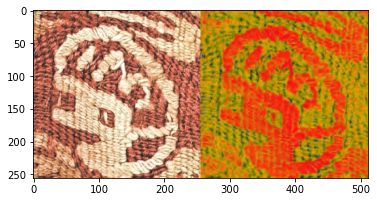

In [6]:
plt.figure()
plt.imshow(sample_image)

In [7]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Separate into label_image and real_image tensors 
    # (we use input_image to generate a fake image that looks like real_image)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    # Convert to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

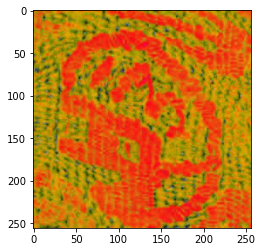

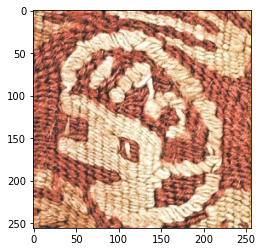

In [8]:
# Display the images
inp, re = load(path+'/fabric_moderate_001_new.jpg')
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

Preprocessing of the images

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [9]:
# Our training set consist of 1000 images
BUFFER_SIZE = 1000
# The batch size of 1 produced better results for the U-Net
BATCH_SIZE = 1
# Original image size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [10]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [11]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [12]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

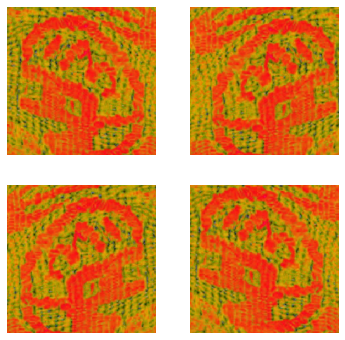

In [15]:
# processed output
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [16]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [17]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [19]:
train_dataset = tf.data.Dataset.list_files(path+'*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [20]:
test_dataset = tf.data.Dataset.list_files(path+'test\\*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [22]:
OUTPUT_CHANNELS = 3

In [24]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [25]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [26]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [27]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [28]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

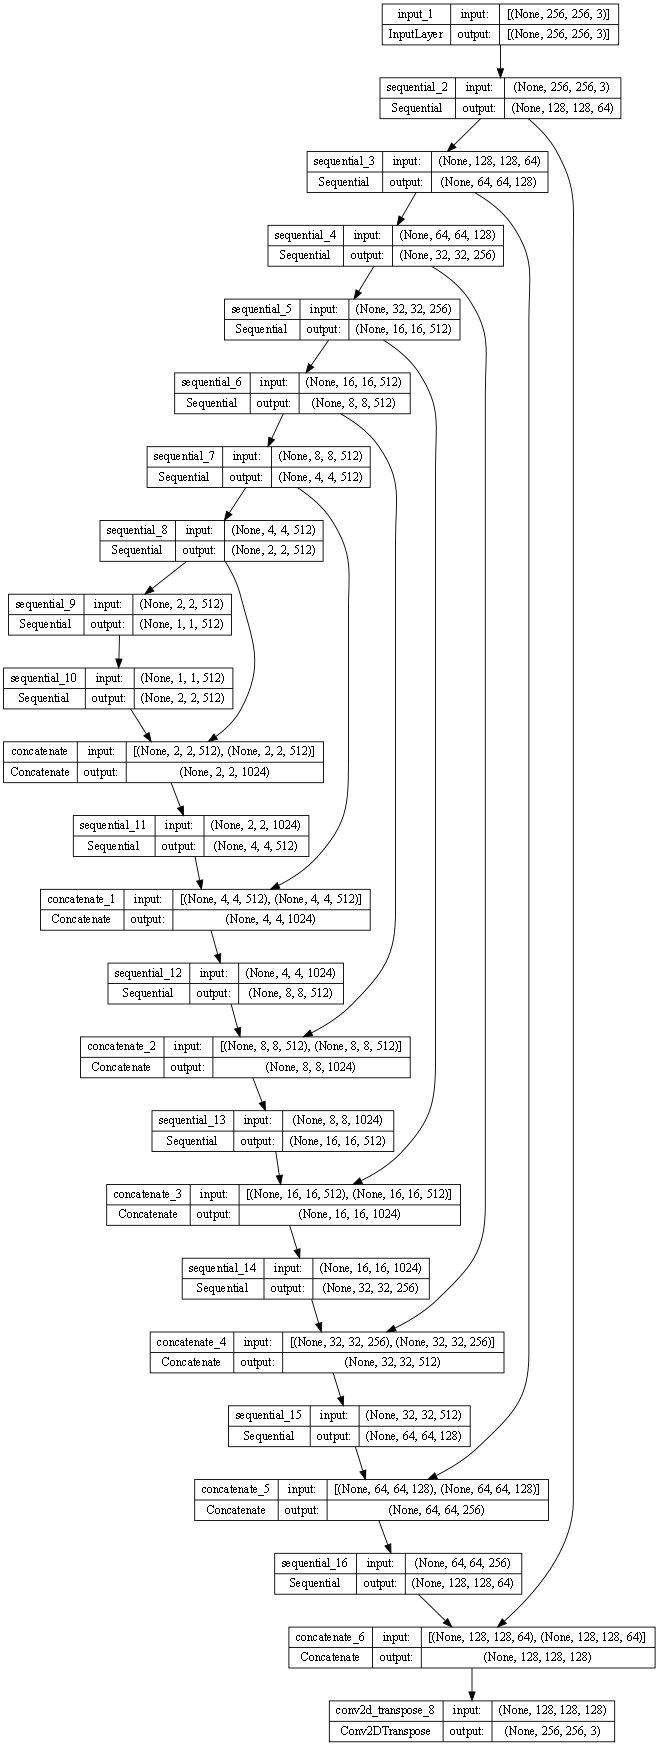

In [29]:
# Visualize the generator model architecture:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


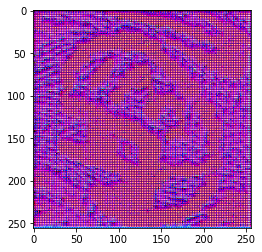

In [30]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [31]:
LAMBDA = 100

In [32]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


In [34]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

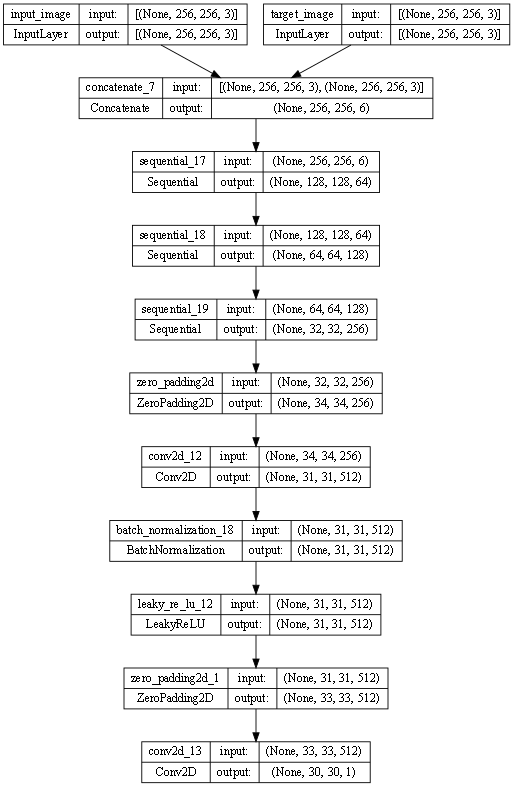

In [35]:
# Visualize the discriminator model architecture:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

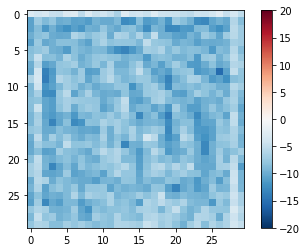

In [36]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
checkpoint_dir = './pix2pix_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [41]:
def generate_images(model, test_input, tar): 
    # training=True is intentional here since we want the batch statistics, while running the model on the test dataset. 
    # If training=False, it'll get the accumulated statistics learned from the training dataset (which we don't want).
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [43]:
log_dir="pix2pix_logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [44]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [45]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 1460.74 sec



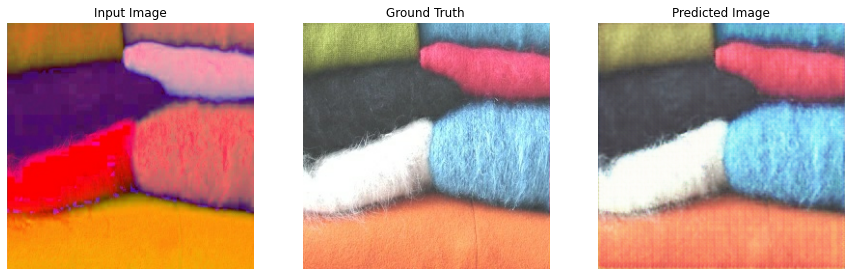

Step: 39k
....................................................................................................

In [47]:
fit(train_dataset, test_dataset, steps=40000)

In [49]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

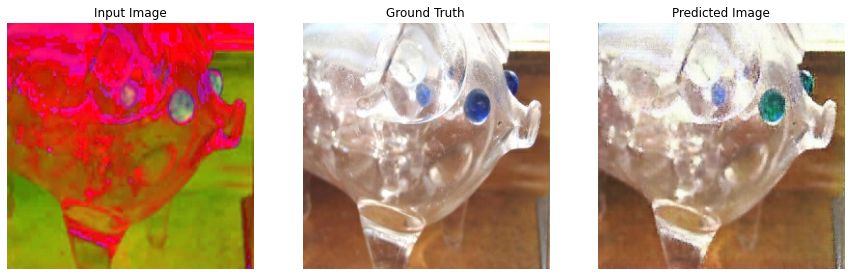

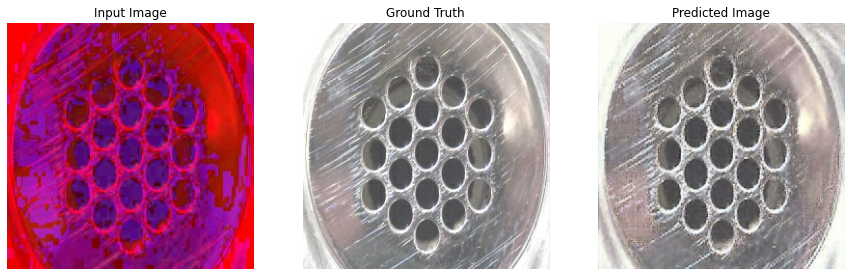

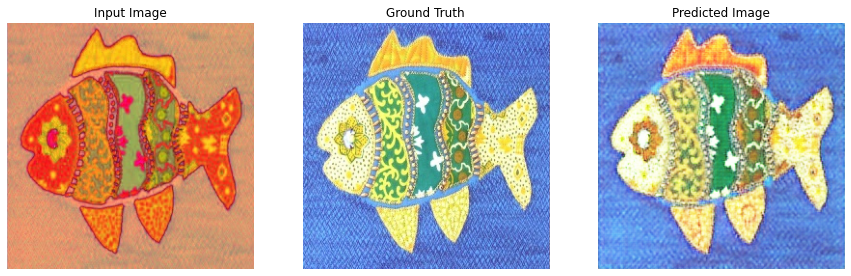

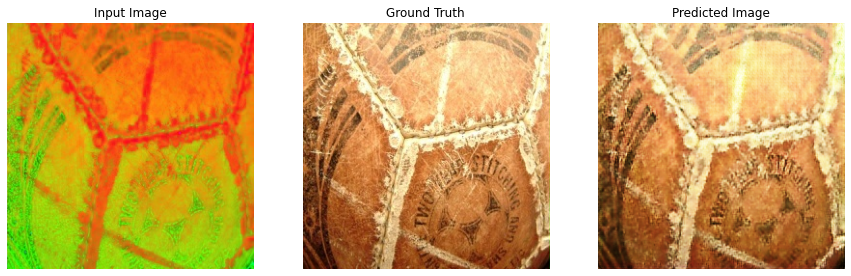

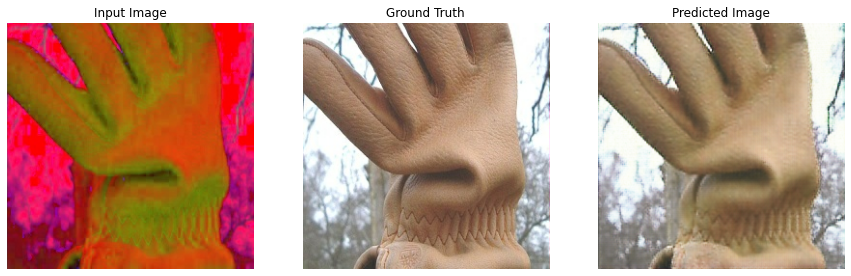

In [50]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

In [80]:
def generate_fake_images(model, test_input, a, save_path, label):
    prediction = model(test_input, training=True)
    # print(type(prediction)) # <class 'tensorflow.python.framework.ops.EagerTensor'>
    
    # save the generated images as additional training data
    tf.keras.preprocessing.image.save_img(save_path+'\\'+label+'_generated_'+a+'.jpg',prediction[0])
    

In [81]:
# Run the trained model to generate a realistic looking image for each original image
# for all images
labels = ['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']
for label in labels:
    generate_dataset = tf.data.Dataset.list_files('W:\\AAAANot_in_WD\\4042\\proj\\FMD\\pix2pix_img_pairs_generate_new\\'+label+'\\*.jpg')

    generate_dataset = generate_dataset.map(load_image_test)
    generate_dataset = generate_dataset.batch(BATCH_SIZE)
    # save the output to the same training data folder
    save_path = 'W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image\\'+label
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    a = 1
    for inp, _ in generate_dataset.take(-1): # take all
        generate_fake_images(generator, inp, str(a), save_path, label)
        a += 1
    #break



In [83]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 728), started 1 day, 13:06:10 ago. (Use '!kill 728' to kill it.)